In [67]:
import time
import gym
import numpy as np
import control as ct
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import matplotlib.pyplot as plt

In [137]:
class KalmanFilter(object):
    """
    This class defines a kalman filter

    l - latent state
    l_a_priori - A priori state estimate
    l_a_posteriori - A posteriori state estimate

    P_a_priori - A priori error covariance
    P_a_posteriori - A posteriori error covariance

    C - observation model
    Q - covariance of the process noise    
    a, b - observation model and bias
    R - covariance of the observation noise
    z - observation

    y_pre - measurement pre-fit residual
    S - Pre-fit residual covariance
    K - Kalman gain
    y_post - measurement post-fit residual
    """
    
    def __init__(self, m, dim_z, batch_size, **kwargs):
        self.m = m
        self.dim_z = dim_z
        self.dim_y = dim_z

        # lambda initializer for identity matrices
        self.eye_init = lambda shape, dtype = np.float32: np.eye(*shape, dtype = dtype)

        self._I = tf.constant(self.eye_init((m, m)), name= 'I')

        '''This section also cannot handle missing kwargs'''
        self.l_0 = kwargs.pop('l_0', None)
        self.P_0 = kwargs.pop('P_0', None)
        self.A = kwargs.pop('A', None)
        self.B = kwargs.pop('B', None)
        self.u = kwargs.pop('u', None)
        self.C = kwargs.pop('C', None)
        self.g = kwargs.pop('g', None)
        self.sigma = kwargs.pop('sigma', None)
        self.y_0 = kwargs.pop('y_0', None)
        self.z_0 = kwargs.pop('z_0', None)
        self.pred_0 = kwargs.pop('pred_0', None)
        self.z = kwargs.pop('z', None)
        
#         self.g_pred = kwargs.pop('g_pred', None)
#         self.sigma_pred = kwargs.pop('sigma_pred', None)
#         self.l_0_pred = kwargs.pop('l_0_pred', None)
#         self.z_0_pred = kwargs.pop('z_0_pred', None)
#         self.A_pred = kwargs.pop('A_pred', None)
#         self.B_pred = kwargs.pop('B_pred', None)
#         self.u_pred = kwargs.pop('u_pred', None)
#         self.C_pred = kwargs.pop('C_pred', None)


    def forward_filter_fn(self, params, inputs):
        """
        Forward step over a batch
        params contains: l_a_posteriori, P_a_posteriori, y_pre
        inputs contains: z, F, g, sigma, a, b

        Calculates prior distributions based on the given posterior distributions and the current residual
                updates posterior distributions based on the new prior distributions
        """
        '''Shapes:
            z = (bs, dim_z)
            l_a_posteriori = (bs, m, dim_z)
            P_a_posteriori = (bs, m, m)
            F = (bs, m, m)
            Q = (bs, m, m)
            R = (bs, dim_z, dim_z)
            a = (bs, m, dim_z)
            b = (bs, dim_z)
        '''
        z, A, B, u, g, sigma, C = inputs
        l_a_posteriori, P_a_posteriori, y_pre, pred = params

#         print('z',z.shape)
#         print('A', A.shape)
#         print('B',B.shape)
#         print('u',u.shape)
#         print('g',g.shape)
#         print('sigma',sigma.shape)
#         print('C', C.shape)
#         print('l_a_posteriori', l_a_posteriori.shape)
#         print('P_a_posteriori', P_a_posteriori.shape)
#         print('y_pre', y_pre.shape)
#         print('pred', pred.shape)
        
        
        l_a_priori = tf.matmul(A,l_a_posteriori) + tf.matmul(B,u)
#         print('l_a_priori',l_a_priori.shape)
        P_a_priori = tf.matmul(tf.matmul(A,P_a_posteriori), A, transpose_b = True) + tf.matmul(g,g, transpose_b=True)
#         print('P_a_priori', P_a_priori.shape)

        y_pre = tf.expand_dims(z,-1) - tf.matmul(C,l_a_priori)

        S = tf.matmul(sigma, sigma, transpose_b=True) + \
            tf.matmul(tf.matmul(C, P_a_priori), C, transpose_b=True)
       
        '''TODO: Compute inverse using cholesky decomposition? Only works if a is matrix
                so z must be multivariate
        '''
#         S_inv = tf.linalg.inv(S)
        S_inv = tfp.math.pinv(S)
        
        
        K = tf.matmul(tf.matmul(P_a_priori, C, transpose_b=True), S_inv)
        l_a_posteriori = l_a_priori + tf.matmul(K,y_pre)
        I_KC = self._I-tf.matmul(K,C)
        P_a_posteriori = tf.matmul(tf.matmul(I_KC, P_a_priori), I_KC, transpose_b=True) + \
                         tf.matmul(tf.matmul(K,tf.matmul(sigma, sigma, transpose_b = True)),
                                   K, transpose_b=True)
        y_post = z - tf.squeeze(tf.matmul(C,l_a_posteriori),-1)
        pred = tf.squeeze(tf.matmul(C, l_a_posteriori),-1)
        
#         print('l_a_posteriori', l_a_posteriori.shape)
#         print('P_a_posteriori', P_a_posteriori.shape)
#         print('y_post', y_post.shape)
#         print('pred', pred.shape)
        return l_a_posteriori, P_a_posteriori, y_post, pred

    def forward_filter(self):
        """
        Compute the forward step in Kalman Filter
        The forward pass is initialized with p(x_1) = N(self.x, self.P)
        We return the mean and covariance for p(x_t|x_tm1) for t=2, ..., T+1
        and the filtering distribution p(x_t|z_1:t) for t=1, ..., T
        """
#         print('z',self.z.shape)
#         print('A', self.A.shape)
#         print('B',self.B.shape)
#         print('u',self.u.shape)
#         print(type(self.u[0,0]))
#         print('g',self.g.shape)
#         print('sigma', self.sigma.shape)
#         print('C', self.C.shape)
#         print('l_0', self.l_0.shape)
#         print('P_0', self.P_0.shape)
#         print('y_0', self.y_0.shape)
#         print('pred_0', self.pred_0.shape)
        forward_states = tf.scan(self.forward_filter_fn,
                                 elems = (trans(self.z),trans(self.A),
                                          trans(self.B),trans(self.u),
                                          trans(self.g),trans(self.sigma),
                                          trans(self.C)),
                                initializer=(self.l_0, self.P_0, self.y_0, self.pred_0))
        
        return forward_states
    
    def Kfilter(self):
        l_filtered, P_filtered, residuals, filtered_prediction = self.forward_filter()
        return trans(l_filtered), trans(P_filtered), trans(residuals), trans(filtered_prediction)
        
    def forward_predict_fn(self, params, inputs):
        """Forward step over a batch
        params contains l_prev, z_prev
        inputs contains F, g, a, b, sigma"""
        
        A, B, g, C, sigma = inputs
        l_prev, z_prev = params
        
#         l_next = tfd.MultivariateNormalDiag(loc = tf.matmul(F, l_prev), scale_diag = g).sample()
        l_next = tf.matmul(A, l_prev) + tf.matmul(B, u)
#         z_next = tfd.Normal(loc = tf.matmul(a, l_prev, transpose_a=True)+b, scale = sigma).sample()
        z_next = tf.matmul(C, l_prev)
        return l_next, z_next
    
    def forward_predict(self):
        """
        Compute the predictions in state space model
        The forward pass is initialized by l_T = p(l_T|z_1:T)
        We return the hidden states l_T+1:T+t and predictions z_T+1:T+t
        """
        
        forward_predictions = tf.scan(self.forward_predict_fn,
                                      elems = (trans(self.A_pred), trans(self.B_pred),
                                               trans(self.g_pred), trans(self.C_pred),
                                               trans(self.sigma_pred)),
                                      initializer = (self.l_0_pred, self.z_0_pred))
        
        return forward_predictions
        
    def Kpredict(self):
        
        l_predicted, z_predicted = self.forward_predict()
        return trans(l_predicted), trans(z_predicted)

In [138]:
def trans(tensor):
    if len(tensor.shape)==3:
        return tf.transpose(tensor, [1,0,2])
    else:
        return tf.transpose(tensor, [1,0,2,3])

In [150]:
class LSTM_SSM_model(object):
    def __init__(self, sess, name, batch_size=1, m = 4, n=4, r=1,
                 learning_rate = 0.00001, lr_decay = 0.95, sigma_upper_bound = 1,
                 sigma_lower_bound = 0, g_upper_bound = 1,
                 g_lower_bound = 0.1, mu_0_upper_bound = 1,mu_0_lower_bound = 0,
                 Sigma_0_upper_bound = 1, Sigma_0_lower_bound = 0, beta = 0.00001,
                 b_upper_bound = 0.25, b_lower_bound = -0.25,thetaacc_error=0,initial_state=0.0001
                ):
        
        '''thetaacc_error gives the amount of random angular acceleration that can be put on the pendulum,
        initial_state gives the amount of variation in the initial state
        '''
        if name == '':
            raise NameError("A model has no name")

        '''This functions assumes the state space model:
            l_(t+1) = A_(t)l_(t)+B(t)u_(t)
            z_(t+1) = C_(t)l_(t)
            where:
            l has dim m
            u has dim r
            z has dim m
            A has dim mxn
            B has dim mxr
            C has dim mxm
            '''
            
        self.sess = sess
        
        '''nn model hyperparameters'''
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.sample_len = 200
        self.global_step = tf.Variable(0, name='global_step',trainable=False)
        self.increment_global_step = tf.assign_add(self.global_step,1, name = 'increment_global_step')
        self.lr_decay = lr_decay
        self.lstm_sizes = [128,64]
        last_lstm = self.lstm_sizes[-1]

        '''dims'''
        self.m = m # size of the state space
        self.dim_z = m
        self.n = n
        self.r = r
        self.lstm_input_dim = m+4 # previous states plus physical parameters
        
        
        self.initial_variance = 1
        
        '''error bounds'''
        self.sigma_upper_bound = sigma_upper_bound
        self.g_lower_bound = g_lower_bound
        self.g_upper_bound = g_upper_bound
        self.mu_0_upper_bound = mu_0_upper_bound
        self.mu_0_lower_bound = mu_0_lower_bound
        self.Sigma_0_upper_bound = Sigma_0_upper_bound
        self.Sigma_0_lower_bound= Sigma_0_lower_bound
        self.b_upper_bound = b_upper_bound
        self.b_lower_bound = b_lower_bound
        self.beta = beta
        
        '''LQR parameters'''
        self.env = gym.make('Custom_CartPole-v0', thetaacc_error=thetaacc_error, initial_state=initial_state)
        self.gravity = self.env.gravity
        self.cart_mass = self.env.masscart
        self.pole_mass = self.env.masspole
        self.pole_length = self.env.length
        self.Q = np.eye(4)*[10,1,1,1]
        self.R = 1
        
        '''Saving model stuff, don"t need for now'''
#         self.model_folder = 'quantitative_tmp/{}'.format(name)
#         if not os.path.isdir(self.model_folder):
#             print('This model has no folder')
#             os.makedirs(self.model_folder)
#         self.saved_model_location = '{}/model.ckpt'.format(self.model_folder)

        self.losses = []
        self.saver = None
        
        with tf.variable_scope('KF', reuse = tf.AUTO_REUSE):
            self.C = tf.get_variable(initializer = tf.tile(tf.expand_dims(tf.expand_dims(tf.eye(self.dim_z),0),0),
                                             (self.batch_size,self.sample_len,1,1)),dtype = tf.float32, name = 'C', trainable = False)
            self.W_A = tf.get_variable(initializer = tf.random.normal([self.batch_size, m*n, last_lstm]),
                                       dtype = tf.float32, name = 'W_A')
            self.bias_A = tf.get_variable(initializer = tf.zeros([self.batch_size, m*n, 1]),
                                          dtype = tf.float32, name = 'bias_A')
            
            self.W_B = tf.get_variable(initializer = tf.random.normal([self.batch_size, m*r, last_lstm]),
                                       dtype = tf.float32, name = 'W_B')
            self.bias_B = tf.get_variable(initializer = tf.zeros([self.batch_size, m*r, 1]),
                                         dtype = tf.float32, name = 'bias_B')

            self.W_g = tf.get_variable(initializer = tf.random.normal([self.batch_size, self.m,
                                                                       last_lstm]),
                                       dtype = tf.float32, name = 'W_g')
            self.bias_g = tf.get_variable(initializer = tf.zeros([self.batch_size, self.m, 1]),
                                          dtype = tf.float32, name = 'bias_g')

            self.W_sigma = tf.get_variable(initializer = tf.random.normal([self.batch_size, self.dim_z,
                                                                           last_lstm]),
                                           dtype = tf.float32, name = 'W_sigma')
            self.bias_sigma = tf.get_variable(initializer = tf.zeros([self.batch_size, self.dim_z, 1]),
                                              dtype = tf.float32, name = 'bias_sigma')

            self.W_mu_0 = tf.get_variable(initializer = tf.random.normal([self.batch_size, self.m,
                                                                          last_lstm]),
                                         dtype = tf.float32, name = 'W_mu_0')
            self.bias_mu_0 = tf.get_variable(initializer = tf.zeros([self.batch_size, self.m, 1]),
                                            dtype = tf.float32, name = 'bias_mu_0')
            
            self.W_Sigma_0 = tf.get_variable(initializer = tf.random.normal([self.batch_size, self.m,
                                                                             last_lstm]),
                                            dtype = tf.float32, name = 'W_Sigma_0')
            self.bias_Sigma_0 = tf.get_variable(initializer = tf.zeros([self.batch_size, self.m, 1]),
                                                dtype = tf.float32, name = 'bias_Sigma_0')
            
            self.P_0 = tf.Variable(tf.tile(tf.expand_dims(self.initial_variance*tf.eye(self.m,dtype = tf.float32),0),
                               (self.batch_size, 1, 1)), name = 'P_0', trainable = False)

            self.y_0 = tf.Variable(tf.zeros([self.batch_size, self.dim_z]), dtype = tf.float32, name = 'y_0', trainable = False)
            self.z_0 = tf.Variable(tf.zeros([self.batch_size, self.dim_z, self.dim_z]), dtype = tf.float32, name = 'z_0', trainable = False)
            self.pred_0 = tf.Variable(tf.zeros([self.batch_size, self.dim_z]), dtype = tf.float32, name = 'pred_0', trainable = False)
            
            
            '''Variables for test range in LQE only'''
#             self.A_test = tf.placeholder(tf.float32, shape = [self.batch_size, self.test_range, m, n], name = 'A_test')
#             self.B_test = tf.placeholder(tf.float32, shape = [self.batch_size, self.test_range, m, r], name = 'B_test')
#             self.g_test = tf.placeholder(tf.float32, shape = [self.batch_size, self.test_range, self.m, 1], name = 'g_test')
#             self.sigma_test = tf.placeholder(tf.float32, shape = [self.batch_size, self.test_range, self.dim_z, 1], name = 'sigma_test')
#             self.l_0_test = tf.placeholder(tf.float32, shape = [self.batch_size, self.m, 1], name = 'l_0_test')
#             self.final_z = tf.placeholder(tf.float32, shape = [self.batch_size, 1, self.dim_z], name = 'final_z')
            
        with tf.variable_scope('LSTM', reuse = tf.AUTO_REUSE):
            self.lstm_input = tf.placeholder(tf.float32, shape=
                                             [self.batch_size, self.sample_len,self.lstm_input_dim],
                                             name = 'lstm_input')

        self.z = tf.placeholder(tf.float32, shape = [self.batch_size, self.sample_len, self.dim_z],
                                name = 'z')        
        
        
    def build_LSTM(self, prev_state = None):
        with tf.name_scope('LSTM'):
            with tf.variable_scope('LSTM', reuse=tf.AUTO_REUSE):

                lstms = [tf.contrib.rnn.LSTMCell(size, reuse=tf.get_variable_scope().reuse) for size in self.lstm_sizes]
                dropouts = [tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob = 0.5) for lstm in lstms]

                cell = tf.contrib.rnn.MultiRNNCell(dropouts)
                if prev_state:
                    initial_state = prev_state
                else:
                    initial_state = cell.zero_state(self.batch_size, tf.float32)
                self.lstm_output, self.final_state = tf.nn.dynamic_rnn(cell, self.lstm_input, initial_state = initial_state)
        return self

    def affine_transformations(self):

        with tf.variable_scope('affine_transformations'):
            
            self.lstm_output = tf.expand_dims(self.lstm_output, -1) # (bs, sample_len, last lstm_size, 1)
            def tile_func(Weights_or_bias):
                if len(Weights_or_bias.shape) == 2:
                    return tf.tile(tf.expand_dims(Weights_or_bias,1), (1,self.sample_len,1))
                elif len(Weights_or_bias.shape) == 3:
                    return tf.tile(tf.expand_dims(Weights_or_bias,1), (1,self.sample_len,1,1))
                else:
                    raise ValueError('Unknown sized Weights or bias array')
                    
            '''TODO: Does tile work by updating all weights for the tile back to the original matrix?    
            '''
            
            W_A = tile_func(self.W_A)
            bias_A = tile_func(self.bias_A)
            W_B = tile_func(self.W_B)
            bias_B = tile_func(self.bias_B)
            W_g = tile_func(self.W_g)
            bias_g = tile_func(self.bias_g)
            W_sigma = tile_func(self.W_sigma)
            bias_sigma = tile_func(self.bias_sigma)

            self.A = tf.reshape(tf.add(tf.matmul(W_A, self.lstm_output), bias_A),
                                [self.batch_size,self.sample_len,self.m,self.n])
            self.B = tf.reshape(tf.add(tf.matmul(W_B, self.lstm_output), bias_B),
                                [self.batch_size,self.sample_len,self.m,self.r])

            transition_error = tf.add(tf.matmul(W_g, self.lstm_output), bias_g)
            self.g = ((self.g_upper_bound-self.g_lower_bound)/(1+tf.exp(-transition_error)))+self.g_lower_bound
            
            observation_error = tf.add(tf.matmul(W_sigma, self.lstm_output), bias_sigma)
            self.sigma = (self.sigma_upper_bound)/(1+tf.exp(-observation_error))
            
            temp_mu_0 = tf.add(tf.matmul(self.W_mu_0, self.lstm_output[:,0,:]), self.bias_mu_0)
            self.mu_0 = ((self.mu_0_upper_bound-self.mu_0_lower_bound)/(1+tf.exp(-temp_mu_0)))+self.mu_0_lower_bound

            temp_Sigma_0 = tf.add(tf.matmul(self.W_Sigma_0, self.lstm_output[:,0,:]), self.bias_Sigma_0)
            self.Sigma_0 = ((self.Sigma_0_upper_bound-self.Sigma_0_lower_bound)/(1+tf.exp(-temp_Sigma_0)))+self.Sigma_0_lower_bound

            l_0_distribution = tfd.MultivariateNormalDiag(loc = self.mu_0, scale_diag = self.Sigma_0)

            self.l_0 = l_0_distribution.sample()
        return self
    
    def build_model(self):
        self.kf_train = KalmanFilter(batch_size=self.batch_size,
                                     m=self.m,
                                     dim_z=self.dim_z,
                                     l_0 = self.l_0,
                                     P_0 = self.P_0,
                                     A = self.A,
                                     B = self.B,
                                     u = self.u,
                                     C = self.C,
                                     g = self.g,
                                     sigma = self.sigma,
                                     z = self.z,
                                     y_0 = self.y_0,
                                     pred_0 = self.pred_0
                                    )
        with tf.variable_scope('KF_results', reuse=tf.AUTO_REUSE):
            self.l_filtered, self.P_filtered, self.residuals, self.filtered_predictions = self.kf_train.Kfilter()

        return self
    
    def likelihood_fn(self, params, inputs):
        '''Compute likelihood over a batch
        params contains: mu, Sigma - the parameters of the likelihood distribution
        inputs contains: calculations of mu: F, a, l_filtered==l_a_posteriori
                        calculations of Sigma: a, F, P_a_posteriori, g, sigma
        '''
        A, B, u, C, g, sigma, l_filtered, P_filtered = inputs
        mu, Sigma = params
        '''
        a (bs, m, 1)
        b (bs, 1)
        F (bs, m, m)
        g (bs, m, 1)
        sigma (bs, 1, 1)
        f (bs, m, 1)
        S (bs, m, m)
        mu (bs, 1, 1)
        Sigma (bs, 1, 1)
        '''

        mu = tf.matmul(C, tf.add(tf.matmul(A,l_filtered), tf.matmul(B,u)))
#         mu = tf.add(tf.matmul(tf.matmul(a, F, transpose_a=True), f), b)

        temp = tf.matmul(tf.matmul(A, P_filtered), A, transpose_b=True) + tf.matmul(g, g, transpose_b=True)
        Sigma = tf.matmul(tf.matmul(C, temp), C, transpose_b=True) + tf.square(sigma)

#         temp = tf.matmul(tf.matmul(F, S), F, transpose_b=True) + tf.matmul(g, g, transpose_b=True)
#         Sigma = tf.matmul(tf.matmul(a, temp, transpose_a=True), a) + tf.square(sigma)
        
        return mu, Sigma
    
    def build_loss(self):
        '''Useful shapes(Ideally):
            l_a_posteriori(batch) - (batch_size, sample_len, m)
            P_a_posteriori(batch) - (batch_size, sample_len, m,m)
            
            inputs:
                mu_0, a, F, l_a_posteriori?
                Sigma_0, a, R, F, P_a_posteriori, Q
        '''


        with tf.variable_scope('loss', reuse = tf.AUTO_REUSE):
#             decayed_learning_rate = tf.train.exponential_decay(self.learning_rate, self.global_step,
#                                                        self.num_batches, self.lr_decay)
#             print('self.C',self.C.shape)
#             print('self.mu_0', self.mu_0.shape)
#             print('self.B',self.B.shape)
#             print('self.u',self.u.shape)
            

            mu_1 = tf.matmul(trans(self.C)[0], self.mu_0)+tf.matmul(trans(self.B)[0],trans(self.u)[0])
            Sigma_1 = tf.matmul(tf.matmul(trans(self.C)[0], tf.linalg.diag(tf.squeeze(self.Sigma_0,-1))),
                                         trans(self.C)[0], transpose_b=True)+tf.square(trans(self.sigma)[0])
#             mu_1 = tf.add(tf.matmul(trans(self.a)[0], self.mu_0, transpose_a=True),trans(self.b)[0])
#             Sigma_1 = tf.matmul(tf.matmul(trans(self.a)[0], tf.linalg.diag(tf.squeeze(self.Sigma_0)),
#                                           transpose_a=True),
#                                 trans(self.a)[0]) + tf.square(trans(self.sigma)[0])
    
            mu, Sigma = tf.scan(self.likelihood_fn,
                                elems = (trans(self.A)[1:], trans(self.B)[1:],
                                         trans(self.u)[1:], trans(self.C)[1:], trans(self.g)[1:],
                                         trans(self.sigma)[1:],trans(self.l_filtered)[:-1],
                                         trans(self.P_filtered)[1:]),
                                initializer = (mu_1, Sigma_1))


            self.mu = tf.squeeze(tf.concat([tf.expand_dims(mu_1,1), trans(mu)], 1),-1)
            self.Sigma = tf.concat([tf.expand_dims(Sigma_1,1),trans(Sigma)], 1)
            
            z_distribution = tfd.MultivariateNormalDiag(loc = self.mu,
                                                        scale_diag = tf.linalg.diag_part(self.Sigma))

            z_probability = z_distribution.prob(self.z)
            self.z_probability = tf.boolean_mask(z_probability, self.z_mask)
            regularizers = tf.nn.l2_loss(self.W_g) + tf.nn.l2_loss(self.W_mu_0) + \
                        tf.nn.l2_loss(self.W_sigma) + tf.nn.l2_loss(self.W_Sigma_0) + \
                        tf.nn.l2_loss(self.W_A) + tf.nn.l2_loss(self.W_B)

            self.loss = tf.reduce_mean(self.beta*regularizers)-tf.square(tf.reciprocal(tf.reduce_sum(tf.cast(self.z_mask, tf.float32))))*tf.reduce_sum(tf.log(self.z_probability+1e-8))
            tf.summary.scalar('loss', self.loss)

#             self.optimizer = tf.train.AdamOptimizer(decayed_learning_rate)
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
            grads_and_vars = self.optimizer.compute_gradients(self.loss)
            capped_grads_and_vars = [(tf.clip_by_norm(grad, 1.), var) for grad, var in grads_and_vars]
            self.train_op = self.optimizer.apply_gradients(capped_grads_and_vars)
        return self
    
    def initialize_variables(self):
        self.saver = tf.train.Saver()
        try:
            self.saver.restore(self.sess, tf.train.latest_checkpoint(self.model_folder))
            print("Restoring model from {}".format(self.saved_model_location))
        except:
            self.sess.run(tf.global_variables_initializer())
            print("Initializing new model at {}".format(self.saved_model_location))
        return self  
    
    def train(self, epochs):
        start = time.time()
        rewards = []
#        merged = tf.summary.merge_all()
#        writer = tf.summary.FileWriter(self.log_dir, self.sess.graph)
        for i in range(epochs):
            preds = []
            epoch_loss = []
            self.sample_from_env()
            
            feed_dict = {self.lstm_input: self.lstm_inputs}
#                summary, loss_, _, _ = self.sess.run([merged, self.loss, self.train_op, self.increment_global_step],
#                                                  feed_dict=feed_dict)
            loss_, _, _ = self.sess.run([self.loss, self.train_op, self.increment_global_step],
                                        feed_dict=feed_dict)
            epoch_loss.append(loss_)
#                writer.add_summary(summary, self.sess.run(self.global_step))
#                if idx % 10 == 0:
#                  print('mini epoch #{}'.format(idx))

            epoch_loss = np.mean(epoch_loss)
            self.losses.append(epoch_loss)
            rewards.append(np.mean(self.rewards))
            if i%50 == 0:
                print("Epoch #{}\tTime Elapsed: {}\tNegative Log-Likelihood {}\n\t\tMean Reward: {}".
                      format(self.sess.run(self.global_step)-1,(time.time()-start)/60,
                             epoch_loss, np.mean(self.rewards)))
#             if i%50 == 0:
#                 self.saver.save(self.sess, self.saved_model_location, global_step = self.global_step)
#                 print("Model Saved at {}".format(self.saved_model_location))
#         self.saver.save(self.sess, self.saved_model_location, global_step = self.global_step)
#         print("Model Saved at {}".format(self.saved_model_location))
        return self.losses, rewards

    def sample_from_env(self):
        #Get A,B matrices from lstm
        self.lstm_inputs = np.reshape(np.array([self.gravity,self.cart_mass,self.pole_mass,
                                           self.pole_length,0,0,0,0]*self.batch_size*self.sample_len, dtype = np.float32),
                                 (self.batch_size,self.sample_len,self.lstm_input_dim))
        feed_dict = {self.lstm_input:self.lstm_inputs}
        A,B = self.sess.run([self.A,self.B],feed_dict=feed_dict)
        
        #setup lists to hold states, controls, and rewards
        states = [[] for _ in range(self.batch_size)]
        u = [[] for _ in range(self.batch_size)]
        rewards = np.array([0]*self.batch_size)
        
        for episode in range(self.batch_size):
            K = [ct.lqr(A[episode,t],B[episode,t],self.Q,self.R)[0] for t in range(200)]
            observation = self.env.reset()
            states[episode].append(observation)
            for t in range(self.sample_len-1):
                u[episode].append(-np.dot(K[t],observation)[0])
#                 u = np.random.normal(1,size=[4])
                observation, reward, done, info = self.env.step(u[episode][t])
                if done:
#                     print("Episode finished at time step {}".format(t+1))
                    break
                states[episode].append(observation)
                rewards[episode]+=1
#             print("Episode complete")  
#         temp = [np.asarray(x) for x in states]
#         max_trial_len = np.max([trial.shape[0] for trial in temp])
#         new_z = []
#         new_control = []
#         for trial in temp:
#             new_z.append(np.pad(trial,((0,max_trial_len-trial.shape[0]),(0,0)),'constant', constant_values=(0)))
#         for trial in 
        self.z, z_mask = arrayify(states)
        self.z_mask = tf.convert_to_tensor(z_mask,dtype=tf.bool)
        self.rewards = rewards
        self.u = np.expand_dims(np.expand_dims(arrayify(u)[0],-1),-1)
        return self
#         return A, B
def arrayify(l):
    temp = [np.asarray(x, dtype = np.float32) for x in l]
    max_trial_len = np.max([trial.shape[0] for trial in temp])
    trial_lens = []
    new = []
    for trial in temp:
        if len(trial.shape) == 2:
            new.append(np.pad(trial,((0,200-trial.shape[0]),(0,0)),'constant', constant_values=(0)))
            trial_lens.append(trial.shape[0])
        else:
            new.append(np.pad(trial,(0,200-trial.shape[0]),'constant',constant_values=0))
            trial_lens.append(trial.shape[0])
    new = np.stack(new,axis = 0)
    if len(new.shape) >2:
        mask = np.zeros(new.shape[:-1], dtype = np.float32)
    else:
        mask = np.zeros(new.shape, dtype = np.float32)
    for idx,length in enumerate(trial_lens):
        mask[idx,:length+1] += 1
    return new, mask.astype(np.bool)

In [151]:
tf.reset_default_graph()
with tf.Session() as sess:
    example = LSTM_SSM_model(sess, name = 'deleteme', batch_size = 3)
#     tvars = tf.trainable_variables()
#     tvars_vals = example.sess.run(tvars)
#     for var, val in zip(tvars, tvars_vals):
#         print(var.name, val.shape)
    example.build_LSTM().affine_transformations()
    example.sess.run(tf.global_variables_initializer())
#     A, B = example.sample_from_env()
    example.sample_from_env()
    example.build_model().build_loss()
    example.sess.run(tf.global_variables_initializer())
    loss, rewards = example.train(epochs = 500)
#     feed_dict = {example.lstm_input:example.lstm_inputs}
#     z_probs,z_mask = example.sess.run([example.z_probability,example.z_mask], feed_dict=feed_dict)

Epoch #0	Time Elapsed: 0.024767438570658367	Negative Log-Likelihood 0.06785818934440613
		Mean Reward: 76.66666666666667
Epoch #50	Time Elapsed: 0.3458739717801412	Negative Log-Likelihood 0.06660673022270203
		Mean Reward: 111.66666666666667
Epoch #100	Time Elapsed: 0.6737528125445048	Negative Log-Likelihood 0.06686623394489288
		Mean Reward: 96.33333333333333
Epoch #150	Time Elapsed: 1.015925681591034	Negative Log-Likelihood 0.06730814278125763
		Mean Reward: 92.33333333333333
Epoch #200	Time Elapsed: 1.3692699313163756	Negative Log-Likelihood 0.0674438625574112
		Mean Reward: 129.66666666666666
Epoch #250	Time Elapsed: 1.7433194160461425	Negative Log-Likelihood 0.06630346179008484
		Mean Reward: 87.33333333333333
Epoch #300	Time Elapsed: 2.102739632129669	Negative Log-Likelihood 0.06536941230297089
		Mean Reward: 92.33333333333333
Epoch #350	Time Elapsed: 2.4273725430170696	Negative Log-Likelihood 0.06646265089511871
		Mean Reward: 75.66666666666667
Epoch #400	Time Elapsed: 2.7696180

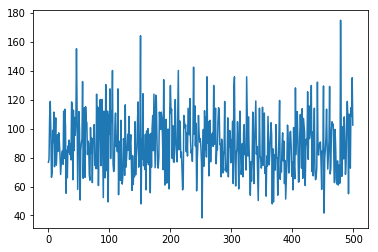

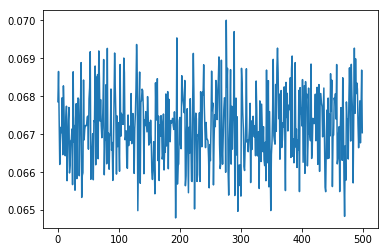

In [152]:
plt.plot(rewards)
plt.show()
plt.plot(loss)
plt.show()

In [ ]:
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        if np.linalg.matrix_rank(ct.ctrb(A[i][j],B[i][j])) != 4:
            print(np.linalg.matrix_rank(ct.ctrb(A[i][j],B[i][j])))

In [ ]:
example.z.shape

In [ ]:
example.z[0,0]

In [ ]:
first = [example.z[0,x,0] for x in range(example.z.shape[0])]
second = [example.z[0,x,1] for x in range(example.z.shape[0])]
third = [example.z[0,x,2] for x in range(example.z.shape[0])]
fourth = [example.z[0,x,3] for x in range(example.z.shape[0])]

In [ ]:
plt.plot(first)
plt.plot(second)
plt.plot(third)
plt.plot(fourth)

In [ ]:
noise_magnitude = np.array([0.01,0.1,0.01,0.1])
av_time = []

env = gym.make('Custom_CartPole-v0', thetaacc_error=2, initial_state=1)
g = env.gravity
M = env.masscart
m = env.masspole
l = env.length
Q = np.eye(4)*[10,1,1,1]
R = 1

'''System of equations'''
A = np.array([[0,1,0,0],[0,0,-m*g/M,0],[0,0,0,1],[0,0,(M+m)*g/(l*M),0]])
B = np.array([[0,1/M,0,-1/(l*M)]]).T


'''LQR'''
import time
K,S,E = ct.lqr(A,B,Q,R)
'''Pole Placement'''
#K = ct.place(A,B,np.array([-1.1,-1.2,-1.3,-1.4]))


#env.x_threshold = 5.0
#env.theta_threshold_radians = 10.0


states = [[] for _ in range(5)]
rewards = np.array([0]*5)
for i_episode in range(5):
    observation = env.reset()
    states[i_episode].append(observation)
    for t in range(500):
#         env.render()
        u = -np.dot(K,observation)
        observation, reward, done, info = env.step(u[0])
        states[i_episode].append(observation)
        if done:
            print("Episode finished at time step {}".format(t+1))
            break
        rewards[i_episode]+=1
    print("Episode complete")
env.close()


In [ ]:
rewards